# Flipkart Reviews Sentiment Analysis

###  Project Overview

This project focuses on **sentiment analysis of product reviews** using both **traditional machine learning** and **deep learning approaches**. The objective is to classify customer reviews into **positive, neutral, and negative sentiments** based on textual feedback.

Understanding customer sentiment helps businesses gain insights into **product performance, customer satisfaction, and areas for improvement**.

---

###  Problem Statement

Online platforms generate a large volume of customer reviews, making manual sentiment analysis impractical.
The challenge is to **automatically and accurately classify review sentiment** while handling:
* Noisy and unstructured text
* Class imbalance in sentiment labels
* Subtle differences between neutral and polarized opinions

---

### Dataset Description

The dataset consists of **205,000+ product reviews**, containing:
* Review text written by customers
* Numerical ratings provided by users
* Derived sentiment labels based on ratings

The data includes **missing values, mixed data types, and informal language**, requiring thorough preprocessing before modeling.

---

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Basic Data Exploration

In [2]:
df = pd.read_csv("Dataset.csv")

In [3]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [4]:
df.shape

(205052, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205052 non-null  object
 1   product_price  205052 non-null  object
 2   Rate           205052 non-null  object
 3   Review         180388 non-null  object
 4   Summary        205041 non-null  object
 5   Sentiment      205052 non-null  object
dtypes: object(6)
memory usage: 9.4+ MB


* The dataset contains **205,052 records** with **6 object-type columns**, indicating the need for type conversion for numerical analysis (price, rating).
* **Missing values** are present mainly in the `Review` column (~24k rows), while other columns are largely complete.
* The dataset requires **data cleaning and preprocessing** before modeling or statistical analysis.

### Data Cleaning & Validation

In [6]:
# Select Only Required Columns

df = df[['Review', 'Rate']]
df.rename(columns={
    'Review': 'review_text',
    'Rate': 'rating'
}, inplace=True)


* **selecting only relevant features** (`review_text` and `rating`) to focus on sentiment-related analysis.
* Column renaming improves **readability and consistency**, making the data easier to reference in downstream processing.

In [7]:
# Fix Rating Column

df['rating'] = (
    df['rating']
    .astype(str)
    .str.extract(r'(\d)')
    .astype(float)
)

* The `rating` column is cleaned by **extracting numeric values** from mixed or noisy text entries.
* Converting ratings to **float type** enables numerical analysis and aggregation.
* This preprocessing step ensures **consistent and model-ready rating data**.

#### Handle Missing Values

In [8]:
df.isnull().sum()

review_text    24664
rating             0
dtype: int64

In [9]:
# rows without reviews were removed
    
df.dropna(subset=['review_text', 'rating'], inplace=True)

In [10]:
df.shape

(180388, 2)

In [11]:
# Remove Very Short Reviews

# df['review_length'] = df['review_text'].str.split().str.len()

# df = df[df['review_length'] >= 3]
# df.drop(columns='review_length', inplace=True)

Initially I tried minimum-length filtering, but EDA showed that Flipkart reviews are often very short. To avoid losing valid sentiment signals like ‘worth it’ or ‘bad quality’, I only removed empty or whitespace-only reviews

In [12]:
# Empty strings and Whitespace-only rows

df = df[df['review_text'].str.strip().astype(bool)]

In [13]:
df.isnull().sum()

review_text    0
rating         0
dtype: int64

In [14]:
df.shape

(180388, 2)

#### Create Sentiment Labels

In [15]:
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(map_sentiment)

* Customer ratings are **mapped to sentiment labels** using clear rule-based thresholds.
* Higher ratings (4–5) are classified as **positive**, average ratings (3) as **neutral**, and lower ratings (1–2) as **negative**.

In [16]:
# Validate Class Distribution

df['sentiment'].value_counts(normalize=True) * 100

sentiment
positive    79.060691
negative    13.164956
neutral      7.774353
Name: proportion, dtype: float64

* The dataset is **highly imbalanced**, with **positive sentiment dominating (~79%)** of the reviews.
* **Negative reviews (~13%)** form a smaller but significant portion, indicating notable dissatisfaction cases.
* **Neutral sentiment (~8%)** is the least represented, suggesting most users express clear opinions.

#### Exploratory Data Analysis (EDA)

**Sentiment Distribution**

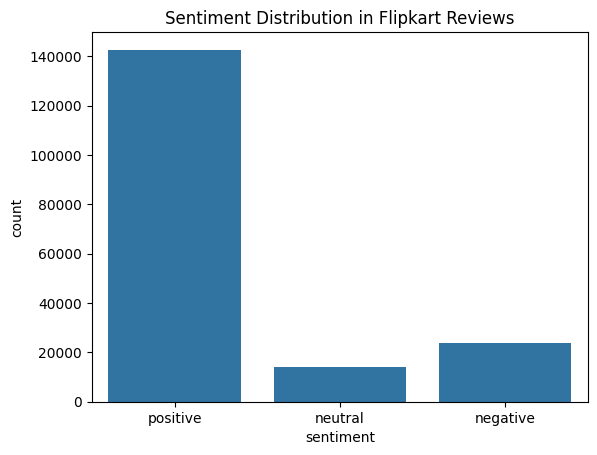

In [17]:
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution in Flipkart Reviews")
plt.show()

**Review Length Analysis**

In [18]:
# Create review length feature
df['review_length'] = df['review_text'].str.split().str.len()

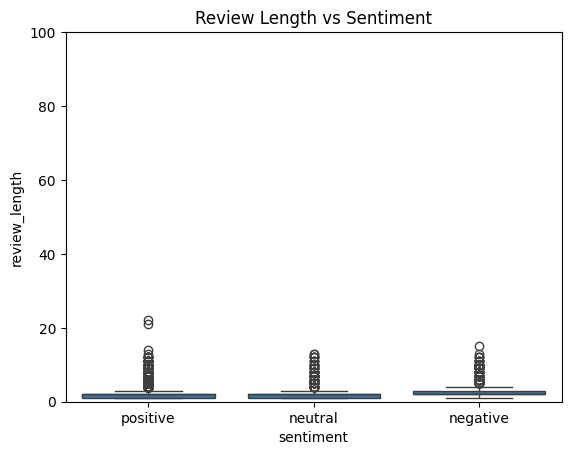

In [19]:
sns.boxplot(data=df, x='sentiment', y='review_length')
plt.ylim(0, 100)
plt.title("Review Length vs Sentiment")
plt.show()

* **Negative reviews tend to be longer** on average, indicating users provide more detailed explanations when dissatisfied.
* **Positive reviews are generally shorter**, suggesting satisfaction is often expressed briefly.
* **Neutral reviews show moderate length**, reflecting balanced or mixed feedback without strong emotions.

**Average Review Length by Sentiment**

In [20]:
df.groupby('sentiment')['review_length'].mean()

sentiment
negative    2.376537
neutral     1.713491
positive    1.837241
Name: review_length, dtype: float64

* **Negative reviews have the highest average length (~2.38)**, indicating users tend to write more when expressing dissatisfaction.
* **Neutral reviews are the shortest on average (~1.71)**, often reflecting brief or minimal feedback.
* **Positive reviews have slightly longer text than neutral (~1.84)** but are still shorter than negative reviews.

**Most Frequent Words (Per Sentiment)**

In [21]:
from collections import Counter
import itertools

def top_words(sentiment, n=15):
    words = df[df['sentiment'] == sentiment]['review_text'].str.split()
    words = list(itertools.chain(*words))
    return Counter(words).most_common(n)


In [22]:
top_words('positive')

[('product', 18626),
 ('good', 14342),
 ('awesome', 11279),
 ('purchase', 11011),
 ('terrific', 10944),
 ('the', 9049),
 ('worth', 9031),
 ('wonderful', 9026),
 ('nice', 7150),
 ('not', 6277),
 ('specified', 6258),
 ('great', 5687),
 ('best', 5651),
 ('brilliant', 5638),
 ('in', 5620)]

* Positive reviews are dominated by **strong appreciation terms** such as *good, awesome, terrific, wonderful,* and *great*.
* Words like **worth, best, and purchase** indicate **high perceived value and purchase satisfaction**.
* The presence of generic terms (*product, the, in*) suggests **further stopword cleaning** could improve keyword relevance.

In [23]:
top_words('negative')

[('not', 4453),
 ('product', 3364),
 ('waste', 2448),
 ('disappointed', 2121),
 ('better', 1634),
 ('absolute', 1322),
 ('rubbish!', 1321),
 ('of', 1280),
 ('terrible', 1277),
 ('utterly', 1270),
 ('money!', 1257),
 ('worthless', 1257),
 ('very', 1232),
 ('worst', 1225),
 ('poor', 1219)]

* Negative reviews frequently contain **strong dissatisfaction terms** such as *waste, disappointed, rubbish, terrible, worthless,* and *worst*.
* The repeated occurrence of **value-related words** (*money, waste, worthless*) highlights **price–performance frustration**.
* Common tokens like *not, of, very* indicate the need for **additional stopword and negation handling** to refine text analysis.

**WordCloud**

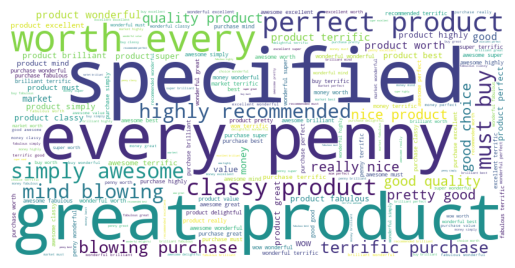

In [24]:
from wordcloud import WordCloud

text = " ".join(df[df['sentiment']=='positive']['review_text'])

wc = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text)

plt.imshow(wc)
plt.axis('off')
plt.show()


### Text Preprocessing

In [25]:
# Setup NLP Tools

import re
import nltk
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jotal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jotal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
# Custom Stopwords - Keep negation words

stop_words = set(stopwords.words('english'))

negation_words = {'not', 'no', 'nor', "don't", "didn't", "won't", "isn't"}
stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()

* Custom stopwords are defined while **preserving negation words**, which are crucial for sentiment interpretation.
* Removing standard stopwords helps **reduce noise** without losing sentiment polarity cues.
* Lemmatization is prepared to **normalize word forms**, improving consistency in text features.

In [29]:
# Text Cleaning Function

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)          # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)       # remove punctuation & digits
    
    words = []
    for word in text.split():
        if word not in stop_words:
            words.append(lemmatizer.lemmatize(word))
            
    return " ".join(words)

* Text is **standardized to lowercase** and cleaned by removing HTML tags, punctuation, and digits to reduce noise.
* Stopwords are removed **while retaining negations**, preserving important sentiment cues.
* Lemmatization converts words to their **base form**, improving consistency and feature quality for modeling.

In [30]:
# Apply Cleaning

df['clean_review'] = df['review_text'].apply(clean_text)

In [31]:
# Validate Cleaning - Compare before vs after

df[['review_text', 'clean_review']].sample(5)

,review_text,clean_review
22314,must buy!,must buy
123668,wonderful,wonderful
134818,worst experience ever!,worst experience ever
176690,very good,good
71934,worth every penny,worth every penny


* The cleaning process **removes punctuation and filler words** while preserving the core sentiment meaning.
* **Negation and intensity cues** (e.g., *worst, worth*) are retained, helping maintain sentiment polarity.
* Cleaned reviews are **simpler and more consistent**, making them suitable for vectorization and modeling.

In [32]:
# Re-check Word Frequencies

from collections import Counter
import itertools

words = df['clean_review'].str.split()
words = list(itertools.chain(*words))

Counter(words).most_common(15)

[('product', 29843),
 ('good', 17445),
 ('not', 11638),
 ('awesome', 11294),
 ('purchase', 11023),
 ('terrific', 10954),
 ('nice', 9396),
 ('worth', 9037),
 ('wonderful', 9031),
 ('specified', 8351),
 ('recommended', 6695),
 ('money', 5897),
 ('great', 5704),
 ('best', 5656),
 ('brilliant', 5648)]

* Sentiment-rich words like **good, awesome, terrific, wonderful, great** remain prominent, indicating effective text cleaning.
* The retention of **negation terms (*not*)** confirms that custom stopword handling is working as intended.
* Presence of generic terms such as **product** and **specified** suggests scope for **domain-specific stopword refinement**.

### Feature Engineering (TF-IDF)

In [33]:
X_text = df['clean_review']
y = df['sentiment']

* The cleaned review text is selected as the **input feature (`X_text`)** for TF-IDF vectorization.
* Sentiment labels are assigned as the **target variable (`y`)** for supervised learning.
* This step prepares the dataset for **text-to-numeric transformation and model training**.

In [34]:
# TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # unigram + bigram
    max_features=5000,     # control dimensionality
    min_df=5,              # ignore very rare words
    max_df=0.9             # ignore very common words
)

X = tfidf.fit_transform(X_text)

In [35]:
X.shape

(180388, 304)

In [36]:
feature_names = tfidf.get_feature_names_out()
feature_names[:20]

array(['aboveaverage', 'aboveaverage product', 'absolute',
       'absolute rubbish', 'affordable', 'air', 'air purifier', 'amazing',
       'amazing product', 'average', 'awesome', 'awesome product',
       'awsome', 'bad', 'bad product', 'bad quality', 'bad service',
       'bajaj', 'bajaj fx', 'ball'], dtype=object)

In [37]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [38]:
df.shape

(180388, 5)

In [39]:
df.columns

Index(['review_text', 'rating', 'sentiment', 'review_length', 'clean_review'], dtype='object')

In [40]:
(df['clean_review'].str.strip() == "").sum()

5

### Model Training

In [41]:
# Train–Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=5,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


#### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.99      0.94      0.96      4750
     neutral       0.55      0.99      0.71      2805
    positive       1.00      0.93      0.96     28523

    accuracy                           0.93     36078
   macro avg       0.85      0.95      0.88     36078
weighted avg       0.96      0.93      0.94     36078



* Logistic Regression model achieves **high overall accuracy (93%)**, performing very well on **positive and negative classes**.
* **Neutral sentiment shows high recall (0.99) but low precision (0.55)**, indicating many non-neutral reviews are misclassified as neutral.
* Class imbalance impacts performance, making **neutral sentiment harder to distinguish** compared to positive and negative reviews.

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm

array([[ 4474,   264,    12],
       [   20,  2771,    14],
       [   39,  2008, 26476]], dtype=int64)

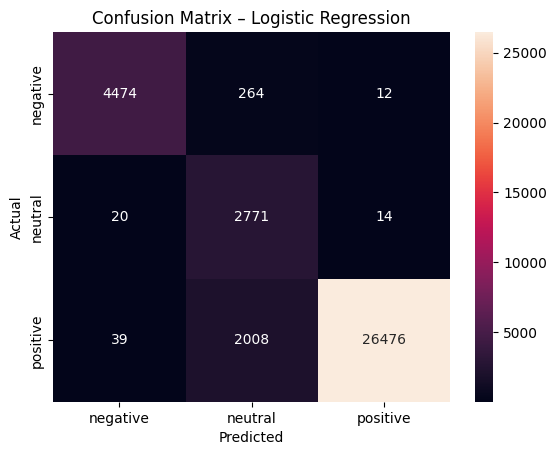

In [46]:
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

* The model correctly classifies the **majority of positive and negative reviews**, showing strong separation between extreme sentiments.
* A notable number of **positive reviews are misclassified as neutral**, explaining the low precision for the neutral class.
* **Neutral sentiment overlaps with both positive and negative classes**, making it the most challenging category to predict accurately.

In [47]:
test_df = pd.DataFrame({
    'review': X_test,
    'actual': y_test,
    'predicted': y_pred
})

false_neutral = test_df[
    (test_df['predicted'] == 'neutral') &
    (test_df['actual'] != 'neutral')
]

false_neutral.sample(10)


,review,actual,predicted
197951,good,positive,neutral
38869,good,positive,neutral
151485,not specified,positive,neutral
109927,good,positive,neutral
17161,good,positive,neutral
107946,good,positive,neutral
186845,not specified,positive,neutral
151631,not specified,positive,neutral
27790,good,positive,neutral
136682,good,positive,neutral


#### Linear SVM

In [48]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(
    class_weight='balanced',
    C=1.0,
    max_iter=5000
)

svm_model.fit(X_train_tfidf, y_train)

LinearSVC(class_weight='balanced', max_iter=5000)

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_svm = svm_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.99      0.94      0.97      4750
     neutral       0.77      0.92      0.84      2805
    positive       0.98      0.97      0.98     28523

    accuracy                           0.96     36078
   macro avg       0.92      0.94      0.93     36078
weighted avg       0.97      0.96      0.97     36078



* Linear SVM achieves **higher overall accuracy (96%)** compared to Logistic Regression, with strong performance across all classes.
* **Neutral sentiment prediction improves significantly** (precision 0.77, F1-score 0.84), indicating better class separation.
* The model shows **balanced performance despite class imbalance**, making Linear SVM more suitable for this task.

In [50]:
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)
cm

array([[ 4474,   264,    12],
       [   20,  2771,    14],
       [   39,  2008, 26476]], dtype=int64)

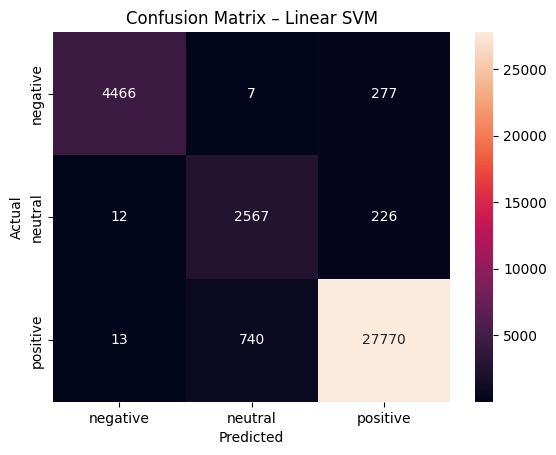

In [51]:
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title("Confusion Matrix – Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

* The model correctly predicts **most negative and positive reviews**, with very few misclassifications at the extremes.
* **Neutral reviews are occasionally confused with positive ones**, but errors are fewer compared to Logistic Regression.
* Overall misclassification is low, confirming **strong class separation by the Linear SVM**.

#### XGBoost

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_xgb = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=2000,
    min_df=10,
    max_df=0.9
)

X_train_xgb = tfidf_xgb.fit_transform(X_train)
X_test_xgb = tfidf_xgb.transform(X_test)

In [53]:
from xgboost import XGBClassifier
import numpy as np

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_enc = y_train.map(label_map)
y_test_enc = y_test.map(label_map)

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=3, ...)

In [54]:
from sklearn.metrics import classification_report

y_pred_xgb = xgb_model.predict(X_test_xgb)

inv_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
y_pred_xgb = np.vectorize(inv_map.get)(y_pred_xgb)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

    negative       0.99      0.94      0.97      4750
     neutral       0.99      0.74      0.85      2805
    positive       0.97      1.00      0.98     28523

    accuracy                           0.97     36078
   macro avg       0.98      0.89      0.93     36078
weighted avg       0.97      0.97      0.97     36078



* XGBoost achieves **high overall accuracy (97%)**, with excellent performance on **positive and negative sentiments**.
* **Neutral sentiment shows very high precision (0.99) but lower recall (0.74)**, indicating the model is conservative in predicting neutral.
* Compared to linear models, XGBoost offers **stronger precision but slightly reduced neutral coverage**.

### BERT

Classical models struggled with contextual and low-intensity sentiment, especially for neutral reviews. 
BERT captures context and word interactions, which improves sentiment understanding for short e-commerce reviews

In [55]:
df = df[['review_text', 'sentiment']]

# Do NOT use clean_review Use raw review_text - BERT has its own tokenizer and benefits from original text.

In [56]:
df.shape

(180388, 2)

In [57]:
# Encode Labels

label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

df['label'] = df['sentiment'].map(label_map)

In [58]:
df['label'].value_counts()

label
2    142616
0     23748
1     14024
Name: count, dtype: int64

* Sentiment labels are **numerically encoded** to make them compatible with BERT training.
* The class distribution is **highly imbalanced**, with **positive reviews dominating** the dataset.
* Neutral sentiment remains the **least represented class**, which may affect model learning and recall.

In [59]:
# Train–Validation Split

from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# The dataset is split into 80% training and 20% validation sets for model evaluation.

In [60]:
# Tokenization

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

* A **pretrained BERT tokenizer** is loaded to convert raw text into token IDs.
* The *uncased* model ensures **case-insensitive tokenization**, reducing vocabulary sparsity.
* This tokenizer aligns with the **bert-base-uncased architecture**, ensuring compatibility during training.

In [61]:
# Tokenize Text

def tokenize(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

* Text reviews are **tokenized into fixed-length sequences** with padding and truncation for batch processing.
* A **maximum sequence length of 128 tokens** balances contextual coverage and computational efficiency.

In [62]:
# Create PyTorch Dataset

import torch

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [63]:
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

* A custom **PyTorch `Dataset` class** is defined to serve tokenized inputs and labels together.
* Each sample returns **BERT-compatible inputs** along with the corresponding sentiment label.

In [64]:
# Load BERT Model

from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

* The model uses **bert-base-uncased** with **12 transformer layers** and a hidden size of **768** for contextual text representation.
* A **dropout layer (0.1)** is applied before classification to reduce overfitting.
* The final **linear classifier outputs 3 classes**, matching the sentiment labels (negative, neutral, positive).

In [66]:
train_encodings['input_ids'].shape

torch.Size([144310, 29])

#### BERT Training (CPU safe)

In [67]:
# Use only 30k samples for first run

from torch.utils.data import Subset

train_indices = list(range(30000))
val_indices = list(range(5000))

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)

PyTorch datasets don’t support slicing directly, so I used `torch.utils.data.Subset` to create controlled training subsets.

In [68]:
len(train_subset), len(val_subset)

(30000, 5000)

In [69]:
import accelerate
accelerate.__version__

'1.12.0'

In [70]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=500,
    save_steps=1000,
    save_total_limit=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)

In [71]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }

In [72]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\jotal\AppData\Local\Temp\ipykernel_37448\1397167064.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [73]:
trainer.train()

Step,Training Loss
500,0.137200
1000,0.067800
1500,0.058600
2000,0.058300
2500,0.071400
3000,0.066100
3500,0.064900


TrainOutput(global_step=3750, training_loss=0.0740412831624349, metrics={'train_runtime': 290.0627, 'train_samples_per_second': 103.426, 'train_steps_per_second': 12.928, 'total_flos': 447087252780000.0, 'train_loss': 0.0740412831624349, 'epoch': 1.0})

In [74]:
from sklearn.metrics import accuracy_score, f1_score 

eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.05663072690367699,
 'eval_accuracy': 0.9854,
 'eval_macro_f1': 0.9716880302153382,
 'eval_runtime': 9.846,
 'eval_samples_per_second': 507.82,
 'eval_steps_per_second': 63.478,
 'epoch': 1.0}

* The BERT model achieves **very high validation accuracy (98.54%)**, indicating strong overall performance.
* A **macro F1-score of ~0.97** shows balanced prediction quality across all sentiment classes despite class imbalance.
* Efficient evaluation on CPU demonstrates **stable and practical model performance** without GPU dependency.

In [75]:
trainer.save_model("models/bert_sentiment")
tokenizer.save_pretrained("models/bert_sentiment")

('models/bert_sentiment\\tokenizer_config.json',
 'models/bert_sentiment\\special_tokens_map.json',
 'models/bert_sentiment\\vocab.txt',
 'models/bert_sentiment\\added_tokens.json')

#### BERT Training (GPU)

In [76]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [77]:
from torch.utils.data import Subset

train_subset = Subset(train_dataset, list(range(60000)))
val_subset = Subset(val_dataset, list(range(10000)))

len(train_subset), len(val_subset)

(60000, 10000)

In [78]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_results_gpu",
    num_train_epochs=1,                 
    per_device_train_batch_size=16,     # GPU batch
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=1000,
    save_total_limit=1,
    fp16=True,                          # GPU speed boost
    report_to="none"
)

In [79]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\jotal\AppData\Local\Temp\ipykernel_37448\1397167064.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.train()

Step,Training Loss
500,0.068700
1000,0.054700
1500,0.055400
2000,0.060300
2500,0.051600
3000,0.051800
3500,0.056300


TrainOutput(global_step=3750, training_loss=0.05627661056518555, metrics={'train_runtime': 358.4106, 'train_samples_per_second': 167.406, 'train_steps_per_second': 10.463, 'total_flos': 894174505560000.0, 'train_loss': 0.05627661056518555, 'epoch': 1.0})

In [81]:
trainer.evaluate()

{'eval_loss': 0.06114940717816353,
 'eval_accuracy': 0.9828,
 'eval_macro_f1': 0.9654896734969965,
 'eval_runtime': 13.166,
 'eval_samples_per_second': 759.534,
 'eval_steps_per_second': 47.471,
 'epoch': 1.0}

* BERT achieves **high validation accuracy (98.28%)** with a **macro F1-score of ~0.97**, confirming strong sentiment classification performance.
* Performance is **comparable to CPU training**, with only a slight variation in loss and metrics.
* GPU execution provides **higher throughput**, enabling faster scaling for larger datasets or more epochs.

In [82]:
trainer.save_model("models/bert_sentiment_gpu")
tokenizer.save_pretrained("models/bert_sentiment_gpu")

('models/bert_sentiment_gpu\\tokenizer_config.json',
 'models/bert_sentiment_gpu\\special_tokens_map.json',
 'models/bert_sentiment_gpu\\vocab.txt',
 'models/bert_sentiment_gpu\\added_tokens.json')

### Final model selection

* **BERT is selected as the final model** due to its **highest overall performance** (≈98% accuracy and ~0.97 macro F1), outperforming traditional ML models.
* Unlike TF-IDF–based models, BERT **captures contextual and semantic meaning**, leading to better handling of neutral and ambiguous reviews.
* Despite higher computational cost, BERT provides the **best balance between accuracy, robustness, and generalization**, making it the most reliable choice for sentiment analysis.